In [9]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import image_file_to_odes_str, execute_template_model_from_sympy_odes
from mira.sources.sympy_ode.agent_pipeline import run_multi_agent_pipeline

client = OpenAIClient()

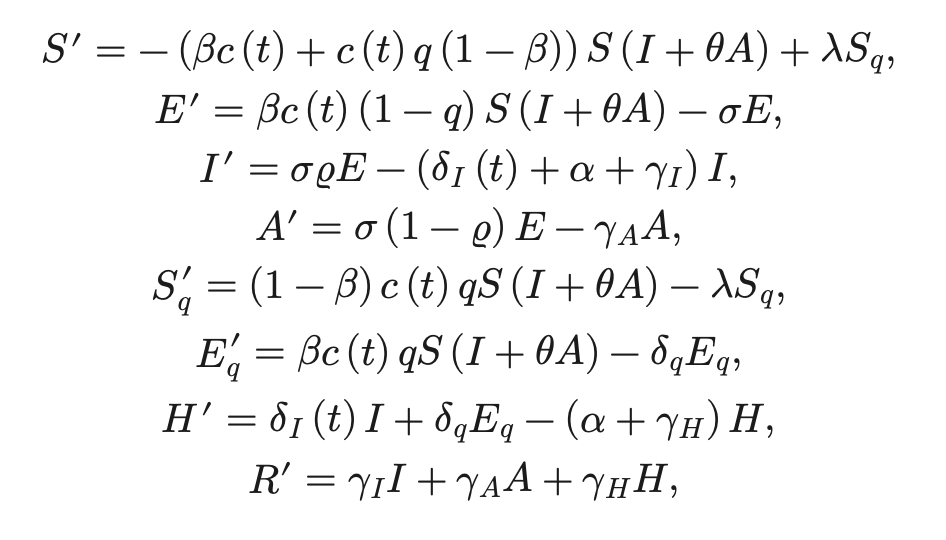

In [2]:
# Extract ODEs from image
biomodel_name = "BIOMD0000000972"

from IPython.display import Image
image_path = f'images/{biomodel_name}.png'
Image(image_path)

In [3]:
ode_str = image_file_to_odes_str(image_path, client=client)
print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

INFO: [2025-10-17 12:16:55] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, A, Sq, Eq, H, R = sympy.symbols("S E I A S_q E_q H R", cls=sympy.Function)

# Define the parameters
beta, c, q, sigma, delta_I, alpha, gamma_I, lambda_ = sympy.symbols("beta c q sigma delta_I alpha gamma_I lambda")
gamma_A, delta_q, gamma_H = sympy.symbols("gamma_A delta_q gamma_H")

odes = [
    sympy.Eq(S(t).diff(t), - (beta * c(t) + c(t) * q * (1 - beta)) * S(t) * (I(t) + A(t)) + lambda_ * Sq(t)),
    sympy.Eq(E(t).diff(t), beta * c(t) * (1 - q) * S(t) * (I(t) + A(t)) - sigma * E(t)),
    sympy.Eq(I(t).diff(t), sigma * q * E(t) - (delta_I(t) + alpha + gamma_I) * I(t)),
    sympy.Eq(A(t).diff(t), sigma * (1 - q) * E(t) - gamma_A * A(t)),
    sympy.Eq(Sq(t).diff(t), (1 - beta) * c(t) * q * S(t) * (I(t) + A(t)) - lambda_ * Sq(t)),
    sympy.Eq(Eq(t).diff(t), beta * c(t) * q * S(t) * (I(t) + A(t)) - delta_q * Eq(t)),
    sympy.Eq(H(t).diff(t), delta_I(t) * I(t) + delta_q * Eq(t) *

In [4]:
corrected_ode_str, corrected_concepts = run_multi_agent_pipeline(
    image_path,
    client,
    biomodel_name=biomodel_name
)

INFO: [2025-10-17 12:16:56] mira.sources.sympy_ode.agent_pipeline - ------------------------------------------------------------
INFO: [2025-10-17 12:16:56] mira.sources.sympy_ode.agent_pipeline - MULTI-AGENT ODE EXTRACTION & VALIDATION PIPELINE
INFO: [2025-10-17 12:16:56] mira.sources.sympy_ode.agent_pipeline - Biomodel: BIOMD0000000972
INFO: [2025-10-17 12:16:56] mira.sources.sympy_ode.agent_pipeline - ------------------------------------------------------------
INFO: [2025-10-17 12:16:56] mira.sources.sympy_ode.agent_pipeline - PHASE 1: ODE Extraction from Image
INFO: [2025-10-17 12:17:24] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-10-17 12:17:24] mira.sources.sympy_ode.agent_pipeline - ODEs extracted from image
INFO: [2025-10-17 12:17:24] mira.sources.sympy_ode.agent_pipeline - Length: 1079 characters
INFO: [2025-10-17 12:17:24] mira.sources.sympy_ode.agent_pipeline - PHASE 2: Concept Grounding
INFO: [2025-10-17 12:17:31] htt

In [10]:
# Now get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
tm = execute_template_model_from_sympy_odes(ode_str=corrected_ode_str, attempt_grounding=True, client=client)

INFO: [2025-10-17 12:19:04] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [11]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
Eq	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'infection_status': 'exposed', 'quarantine_status': 'quarantined'}
A	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'infection_status': 'infected', 'disease_severity': 'asymptomatic'}
E	{'apollosv': '00000154'}	{'species': 'ncbitaxon:9606', 'infection_status': 'exposed'}
I	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'infection_status': 'infected', 'disease_severity': 'moderate'}
R	{'ido': '0000592'}	{'species': 'ncbitaxon:9606', 'recovery_status': 'recovered'}
H	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'hospitalization': 'ncit:C25179'}
S	{'ido': '0000514'}	{'species': 'ncbitaxon:9606', 'infection_status': 'susceptible'}
Sq	{'ido': '0000514'}	{'species': 'ncbitaxon:9606', 'infection_status': 'susceptible', 'quarantine_status': 'quarantined'}


In [12]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[Derivative(Eq, t), =,                           -Eq*delta_q + S*beta*c*q*(A + I)],
[ Derivative(E, t), =,                        -E*sigma + S*beta*c*(1 - q)*(A + I)],
[ Derivative(A, t), =,                               -A*gamma_A + E*sigma*(1 - q)],
[ Derivative(I, t), =,                  E*q*sigma - I*(alpha + delta_I + gamma_I)],
[ Derivative(R, t), =,                          A*gamma_A + H*gamma_H + I*gamma_I],
[ Derivative(H, t), =,                   Eq*delta_q*(alpha + gamma_H) + I*delta_I],
[ Derivative(S, t), =, -S*beta*c*q*(A + I) - S*beta*c*(1 - q)*(A + I) + Sq*lambda],
[Derivative(Sq, t), =,                       S*c*q*(1 - beta)*(A + I) - Sq*lambda]])